# Covid-19 cases in City of Toronto neighborhoods


## Introduction/Business Problem

Over the past few months of the covid-19 outbreak, it is well established that an effective way to control the spread of novel coronavirus is by testing the symptomatic and potential cases, followed quarantining the positive cases. Although testing is critical, healthcare sector has a defined capacity and constrained resources, rendering the idea of testing an entire nation over and over for a period of time impractical. The need for a more focused testing strategy was highlighted by the researchers recently, which would lead to efficient use of the resources available at hand. One way to do so, is by studying the spread of covid-19 at a greater level of granularity. Therefore, instead of viewing total counts in states and provinces, study the number of cases at neighborhood levels. Such approach could present a more focused point of view for defining an effective testing strategy making best use of available resources.

## Data

To study the number of covid-19 cases in Toronto at neighborhood level, covid-19 neighborhood data made available via City of Toronto municipality [this link](https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/) is used here. The coordinates of each neighborhood are obtained from Nominatim geolocation service through GeoPy library in Python [this link](https://geopy.readthedocs.io/en/stable/). Moreover, Toronto neighborhoods population data is extracted from Wellbeing Toronto application [this link](https://map.toronto.ca/wellbeing/) to see if there is a relationship between the number of covid-19 cases in each neighborhood with population, level of income and age. Finally, `Foursquare` venues data are used to see what type of venues are most popular in the neighborhood with highest numbers of covid-19 cases. See Tables 1 to 4 in the following.

In [1]:
import pandas as pd
import numpy as np
import requests
#import lxml.html as lh
from pypostalcode import PostalCodeDatabase
#import re
#from operator import itemgetter
import geocoder
#import wget
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans # import k-means from clustering stage
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
#import geojson
import matplotlib.pyplot as plt
import seaborn as sns
import folium.plugins
from folium.plugins import MarkerCluster
folium.plugins.MarkerCluster()
import warnings
warnings.filterwarnings('ignore')

The number of covid-19 cases in each neighborhood as of July, 14th 2020 is presented in dataframe `df_covid` below.

In [2]:
path_covid = '~\CityofToronto_COVID-19_NeighbourhoodData.csv'

#### Table 1

In [3]:
df_covid = pd.read_csv(path_covid)
df_covid.iloc[0:140,:].sort_values(by = 'Case Count', ascending = False).head(10)

,Neighbourhood ID,Neighbourhood Name,Case Count,"Rate per 100,000 people"
78,NaN,Missing Address/Postal Code,613,NaN
45,25.0,Glenfield-Jane Heights,499,1636.548490
125,1.0,West Humber-Clairville,471,1413.904899
82,2.0,Mount Olive-Silverstone-Jamestown,471,1429.265036
33,26.0,Downsview-Roding-CFB,443,1263.836586
139,27.0,York University Heights,420,1522.125177
58,14.0,Islington-City Centre West,351,798.362334
127,113.0,Weston,318,1767.452201
106,131.0,Rouge,303,651.668961
13,24.0,Black Creek,299,1375.534802


- Acquiring the geolocation of neighborhoods using `Nominatim` geolocation service.

In [4]:
address = []
location = []
latitude = []
longitude = []
count = 0
for i in range(len(df_covid)-2):
    try:
        address = df_covid['Neighbourhood Name'][i]+', Toronto, Ontario, Canada'
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address, timeout=10)
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except AttributeError:
        try:
            address = address.replace(', Toronto, Ontario, Canada','').split('-')[0]+', Toronto, Ontario, Canada'
            geolocator = Nominatim(user_agent="foursquare_agent")
            location = geolocator.geocode(address, timeout=10)
            latitude.append(location.latitude)
            longitude.append(location.longitude)
        except AttributeError:
            try:
                print(address)
                address = df_covid['Neighbourhood Name'][i]+', Toronto, Ontario, Canada'
                print(address)
                address = address.replace(', Toronto, Ontario, Canada','').split('-')[1]+', Toronto, Ontario, Canada'
                print(address)
                geolocator = Nominatim(user_agent="foursquare_agent")
                location = geolocator.geocode(address, timeout=10)
                latitude.append(location.latitude)
                longitude.append(location.longitude)
            except IndexError:
                latitude.append('NaN')
                longitude.append('NaN')
        
    count += 1
    print(count, latitude[i], longitude[i])

1 43.8080383 -79.2664391
2 43.7853531 -79.2785494
3 43.6017173 -79.5452325
4 43.6703377 -79.407117
5 43.7348039 -79.3572426
6 43.76389295 -79.45636693710946
7 43.6673421 -79.3884571
8 43.7691966 -79.3766617
9 43.7981268 -79.3829726
10 43.7373876 -79.4109253
11 43.6950296 -79.4716835
12 43.7535196 -79.2553355
Birchcliffe, Toronto, Ontario, Canada
Birchcliffe-Cliffside, Toronto, Ontario, Canada
Cliffside, Toronto, Ontario, Canada
13 43.7111699 -79.2481769
14 43.6954005 -79.485495
15 43.781769 -79.4237615
16 43.70304535 -79.45134360044906
17 43.7381512 -79.3725113
18 43.6839242 -79.3569642
19 43.7007782 -79.4945217
20 43.6644734 -79.3669861
21 43.6867527 -79.4595746
22 43.6781015 -79.409415775
23 43.7874914 -79.1507681
24 43.6799189 -79.3886888
25 43.7088231 -79.2959856
26 43.7431757 -79.4517261
27 43.7218363 -79.2362138
28 43.677954 -79.4430828
29 43.6864333 -79.3003555
30 43.6864333 -79.3003555
31 43.7926732 -79.3547219
32 43.7528467 -79.282067
33 43.6653069 -79.4326362
34 43.7492988 -7

In [5]:
latitude.append('NaN')
latitude.append('NaN')
longitude.append('NaN')
longitude.append('NaN')

In [6]:
df_covid['Latitude'] = latitude
df_covid['Longitude'] = longitude

#### Table 2

In [7]:
df_covid.iloc[0:140,:].sort_values(by = 'Case Count', ascending = False).head(10)

,Neighbourhood ID,Neighbourhood Name,Case Count,"Rate per 100,000 people",Latitude,Longitude
78,NaN,Missing Address/Postal Code,613,NaN,NaN,NaN
45,25.0,Glenfield-Jane Heights,499,1636.548490,43.6535,-79.3839
125,1.0,West Humber-Clairville,471,1413.904899,43.6824,-79.4808
82,2.0,Mount Olive-Silverstone-Jamestown,471,1429.265036,43.6535,-79.3839
33,26.0,Downsview-Roding-CFB,443,1263.836586,43.7493,-79.4622
139,27.0,York University Heights,420,1522.125177,NaN,NaN
58,14.0,Islington-City Centre West,351,798.362334,43.6488,-79.549
127,113.0,Weston,318,1767.452201,43.7002,-79.5162
106,131.0,Rouge,303,651.668961,43.8049,-79.1658
13,24.0,Black Creek,299,1375.534802,43.6954,-79.4855


- Obtaining the geolocation of City of Toronto:

In [8]:
address0 = 'City of Toronto, ON'
geolocator0 = Nominatim(user_agent="to_explorer")
location0 = geolocator.geocode(address0)
latitude0 = location0.latitude
longitude0 = location0.longitude
print('The geograpical coordinate of City of Toronto are {}, {}.'.format(latitude0, longitude0))

The geograpical coordinate of City of Toronto are 43.7170226, -79.41978303501344.


- Cleaning the `df_covid` dataframe:

In [9]:
indx_rm = np.where(df_covid['Latitude'] == 'NaN')[0].tolist()

In [10]:
df_covid.drop(df_covid.index[indx_rm], inplace = True)

In [11]:
df_covid.reset_index(inplace = True)

In [12]:
df_covid.drop(columns = 'index', inplace = True)

#### Figure 1

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude0, longitude0], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, case in zip(df_covid['Latitude'], df_covid['Longitude'], df_covid['Neighbourhood Name'], df_covid['Case Count']):
    label = '{}, {} cases'.format(neighborhood, case)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [14]:
# create map of Toronto using latitude and longitude values
map_toronto2 = folium.Map(location=[latitude0, longitude0], zoom_start=10)

marker_cluster = MarkerCluster().add_to(map_toronto2)

# add markers to map
for lat, lng, neighborhood, case in zip(df_covid['Latitude'], df_covid['Longitude'], df_covid['Neighbourhood Name'], df_covid['Case Count']):
    label = '{}, {} cases'.format(neighborhood, case)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(marker_cluster)  
    
map_toronto2

- Let's check the neighbourhoods with highest number of cases

In [15]:
df_covid.sort_values(by = 'Case Count', ascending = False).head(10)

,Neighbourhood ID,Neighbourhood Name,Case Count,"Rate per 100,000 people",Latitude,Longitude
45,25.0,Glenfield-Jane Heights,499,1636.548490,43.6535,-79.3839
121,1.0,West Humber-Clairville,471,1413.904899,43.6824,-79.4808
78,2.0,Mount Olive-Silverstone-Jamestown,471,1429.265036,43.6535,-79.3839
33,26.0,Downsview-Roding-CFB,443,1263.836586,43.7493,-79.4622
57,14.0,Islington-City Centre West,351,798.362334,43.6488,-79.549
123,113.0,Weston,318,1767.452201,43.7002,-79.5162
102,131.0,Rouge,303,651.668961,43.8049,-79.1658
13,24.0,Black Creek,299,1375.534802,43.6954,-79.4855
128,137.0,Woburn,298,557.165560,43.7598,-79.2253
62,6.0,Kingsview Village-The Westway,267,1213.636364,43.6995,-79.5563


- The data shows `Glenfield-Jane Heights`, `Mount Olive-Silverstone-Jamestown`, `West Humber-Clairville`, `Downsview-Roding-CFB` and `York University Heights` are the Toronto neighbourhoods with highest number of  covid-19 cases as of July 5th, 2020.

### Age distribution of cases

Data is acquired from [COVID-19: Status of Cases in Toronto](https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/).

#### Table 3

In [16]:
df_age = pd.read_csv('case_by_age.csv')
df_age['Age Group'][0] = '0-19'
df_age

,Age Group,% of Total Case Count,Case Count
0,0-19,6.122038,912
1,20-29,14.298181,2130
2,30-39,14.063234,2095
3,40-49,14.076660,2097
4,50-59,15.808552,2355
5,60-69,10.706854,1595
6,70-79,7.068537,1053
7,80-89,10.263812,1529
8,90+,7.377324,1099
9,Unknown,0.214808,32


We'll assume that this distribution is similar over all neighborhoods in Toronto.

### Severity of cases by age

Data is acquired from [COVID-19: Status of Cases in Toronto](https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/).

#### Table 4

In [17]:
df_severity = pd.read_csv('severity_by_age.csv')
df_severity['Age Group'][0] = '0-19'
df_severity

,Age Group,ICU Cases,Deaths,Hospitalized Cases,Intubated Cases
0,0-19,3,1,13,1
1,20-29,11,1,51,7
2,30-39,12,1,85,7
3,40-49,40,9,147,24
4,50-59,96,34,301,77
5,60-69,109,102,337,80
6,70-79,86,208,355,63
7,80-89,39,398,383,27
8,90+,4,366,174,1
9,Unknown,0,0,0,0


### Well being Toronto demographics data

- Let's add the data from **Wellbeing Toronto** to see if we could find a relation between number of cases and demographic properties of each neighbourhood. 

In [18]:
df_wellbeing = pd.read_csv('wellbeing_toronto.csv')

In [19]:
df_wellbeing.drop(columns = ['Combined Indicators'], inplace = True)

#### Table 5

In [20]:
df_wellbeing.head(10)

,Neighbourhood,Neighbourhood Id,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 4 years,Pop 5 - 9 years,Pop 10 - 14 years,Pop 15 - 19 years,...,Pop 55 - 59 years,Pop 60 - 64 years,Pop 65 - 69 years,Pop 70 - 74 years,Pop 75 - 79 years,Pop 80 - 84 years,Pop 85 - 89 years,Pop 90 - 94 years,Pop 95 - 99 years,Pop 100 years and over
0,West Humber-Clairville,1,3790,23.82,30.09,33312,1540,1720,1790,2325,...,2195,1795,1595,1185,885,700,615,160,50,5
1,Mount Olive-Silverstone-Jamestown,2,5010,37.57,4.60,32954,2190,2500,2415,2585,...,1955,1520,1285,885,630,465,300,70,10,0
2,Thistletown-Beaumond Heights,3,1080,42.26,3.40,10360,540,600,595,650,...,660,535,490,375,335,320,350,100,20,5
3,Rexdale-Kipling,4,1110,23.31,2.50,10529,560,515,565,635,...,870,650,520,350,295,270,300,85,15,0
4,Elms-Old Rexdale,5,1190,24.71,2.90,9456,540,605,660,690,...,730,525,415,305,235,180,145,40,5,0
5,Kingsview Village-The Westway,6,2800,35.69,5.10,22000,1425,1485,1325,1500,...,1330,1220,1015,750,660,595,575,170,20,0
6,Willowridge-Martingrove-Richview,7,1610,30.46,5.50,22156,1175,1230,1155,1275,...,1600,1305,1245,945,920,910,885,240,30,10
7,Humber Heights-Westmount,8,820,32.82,2.80,10948,440,490,515,525,...,790,720,580,485,495,530,950,375,70,15
8,Edenbridge-Humber Valley,9,900,46.41,5.50,15535,565,705,845,885,...,1230,1155,910,635,550,520,665,200,55,0
9,Princess-Rosethorn,10,460,39.52,5.20,11051,450,585,730,780,...,1045,810,630,435,335,315,325,115,10,0


In [21]:
df_wellbeing.sort_values(by = 'Total Population', ascending = False)

,Neighbourhood,Neighbourhood Id,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 4 years,Pop 5 - 9 years,Pop 10 - 14 years,Pop 15 - 19 years,...,Pop 55 - 59 years,Pop 60 - 64 years,Pop 65 - 69 years,Pop 70 - 74 years,Pop 75 - 79 years,Pop 80 - 84 years,Pop 85 - 89 years,Pop 90 - 94 years,Pop 95 - 99 years,Pop 100 years and over
76,Waterfront Communities-The Island,77,4480,31.61,7.60,65913,2135,925,605,1140,...,2560,2120,1760,1225,740,530,365,90,20,5
136,Woburn,137,6860,27.73,12.20,53485,3140,3365,3125,3400,...,3490,2755,2220,1810,1550,1330,1130,305,60,5
50,Willowdale East,51,6260,28.90,5.00,50434,2290,1930,1710,2680,...,2985,2475,2080,1445,1130,780,830,230,40,5
130,Rouge,131,3760,21.95,37.60,46496,2370,2810,2775,3265,...,3555,3135,2590,1670,1005,680,685,205,65,10
116,L'Amoreaux,117,5840,30.73,7.10,43993,2035,2045,2050,2625,...,3120,2810,2575,1855,1770,1440,1345,370,70,10
13,Islington-City Centre West,14,6140,31.01,16.40,43965,2225,1930,1705,1920,...,2920,2480,2050,1545,1240,1080,1480,450,115,30
131,Malvern,132,5170,38.63,8.90,43794,2405,2680,2815,3170,...,2980,2555,2255,1535,1045,590,445,110,30,0
92,Dovercourt-Wallace Emerson-Juncti,93,3860,35.06,3.70,36625,1740,1480,1260,1405,...,2200,1735,1375,1045,890,640,595,170,30,0
25,Downsview-Roding-CFB,26,4060,23.72,14.90,35052,2010,1870,1865,2025,...,2505,1875,1520,1105,1085,950,870,210,35,0
44,Parkwoods-Donalda,45,3370,33.60,7.50,34805,1800,1980,2055,2295,...,2410,1855,1530,1200,950,800,775,185,40,10


In [22]:
df_wellbeing.rename(columns = {'   In Labour Force':'In Labour Force'}, inplace = True)

## Methodology

### Organizing wellbeing data

In this part some of the age group columns of wellbeing dataframe are added to follow the age group columns of `df_severity` and `df_age dataframes`.

In [23]:
pd.set_option('display.max_columns', None)
df_wellbeing.head()

,Neighbourhood,Neighbourhood Id,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 4 years,Pop 5 - 9 years,Pop 10 - 14 years,Pop 15 - 19 years,Pop 20 - 24 years,Pop 25 - 29 years,Pop 30 - 34 years,Pop 35 - 39 years,Pop 40 - 44 years,Pop 45 - 49 years,Pop 50 - 54 years,Pop 55 - 59 years,Pop 60 - 64 years,Pop 65 - 69 years,Pop 70 - 74 years,Pop 75 - 79 years,Pop 80 - 84 years,Pop 85 - 89 years,Pop 90 - 94 years,Pop 95 - 99 years,Pop 100 years and over
0,West Humber-Clairville,1,3790,23.82,30.09,33312,1540,1720,1790,2325,3120,2785,2345,2035,1980,2225,2475,2195,1795,1595,1185,885,700,615,160,50,5
1,Mount Olive-Silverstone-Jamestown,2,5010,37.57,4.60,32954,2190,2500,2415,2585,2655,2400,2250,2185,2275,2315,2190,1955,1520,1285,885,630,465,300,70,10,0
2,Thistletown-Beaumond Heights,3,1080,42.26,3.40,10360,540,600,595,650,760,680,715,665,610,720,770,660,535,490,375,335,320,350,100,20,5
3,Rexdale-Kipling,4,1110,23.31,2.50,10529,560,515,565,635,720,715,680,640,680,770,815,870,650,520,350,295,270,300,85,15,0
4,Elms-Old Rexdale,5,1190,24.71,2.90,9456,540,605,660,690,750,600,575,550,540,680,755,730,525,415,305,235,180,145,40,5,0


In [24]:
df_wellbeing['Pop 0 - 19'] = df_wellbeing['Pop 0 - 4 years'] + df_wellbeing['Pop 5 - 9 years'] + df_wellbeing['Pop 10 - 14 years'] + df_wellbeing['Pop 15 - 19 years']
df_wellbeing['Pop 20 - 29'] = df_wellbeing['Pop 20 - 24 years'] + df_wellbeing['Pop 25 - 29 years']
df_wellbeing['Pop 30 - 39'] = df_wellbeing['Pop 30 - 34 years'] + df_wellbeing['Pop 35 - 39 years']
df_wellbeing['Pop 40 - 49'] = df_wellbeing['Pop 40 - 44 years'] + df_wellbeing['Pop 45 - 49 years']
df_wellbeing['Pop 50 - 59'] = df_wellbeing['Pop 50 - 54 years'] + df_wellbeing['Pop 55 - 59 years']
df_wellbeing['Pop 60 - 69'] = df_wellbeing['Pop 60 - 64 years'] + df_wellbeing['Pop 65 - 69 years']
df_wellbeing['Pop 70 - 79'] = df_wellbeing['Pop 70 - 74 years'] + df_wellbeing['Pop 75 - 79 years']
df_wellbeing['Pop 80 - 89'] = df_wellbeing['Pop 80 - 84 years'] + df_wellbeing['Pop 85 - 89 years']
df_wellbeing['Pop 90+'] = df_wellbeing['Pop 90 - 94 years'] + df_wellbeing['Pop 95 - 99 years'] + df_wellbeing['Pop 100 years and over']

df_wellbeing.drop(columns = ['Pop 0 - 4 years','Pop 5 - 9 years','Pop 10 - 14 years','Pop 15 - 19 years','Pop 20 - 24 years','Pop 25 - 29 years','Pop 30 - 34 years','Pop 35 - 39 years','Pop 40 - 44 years','Pop 45 - 49 years','Pop 50 - 54 years','Pop 55 - 59 years','Pop 60 - 64 years','Pop 65 - 69 years','Pop 70 - 74 years','Pop 75 - 79 years','Pop 80 - 84 years','Pop 85 - 89 years','Pop 90 - 94 years','Pop 95 - 99 years','Pop 100 years and over'], inplace = True)

In [25]:
df_wellbeing.head()

,Neighbourhood,Neighbourhood Id,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 19,Pop 20 - 29,Pop 30 - 39,Pop 40 - 49,Pop 50 - 59,Pop 60 - 69,Pop 70 - 79,Pop 80 - 89,Pop 90+
0,West Humber-Clairville,1,3790,23.82,30.09,33312,7375,5905,4380,4205,4670,3390,2070,1315,215
1,Mount Olive-Silverstone-Jamestown,2,5010,37.57,4.60,32954,9690,5055,4435,4590,4145,2805,1515,765,80
2,Thistletown-Beaumond Heights,3,1080,42.26,3.40,10360,2385,1440,1380,1330,1430,1025,710,670,125
3,Rexdale-Kipling,4,1110,23.31,2.50,10529,2275,1435,1320,1450,1685,1170,645,570,100
4,Elms-Old Rexdale,5,1190,24.71,2.90,9456,2495,1350,1125,1220,1485,940,540,325,45


The `Total Population` column values are slightly different from the summation of populations by all age groups, hence, it is replaced by the summation of populations of age groups which is a more recent data. 

In [26]:
df_wellbeing['Total Population'] = df_wellbeing.iloc[:,6] + df_wellbeing.iloc[:,7] + df_wellbeing.iloc[:,8] + df_wellbeing.iloc[:,9] + df_wellbeing.iloc[:,10] + df_wellbeing.iloc[:,11] + df_wellbeing.iloc[:,12] + df_wellbeing.iloc[:,13] + df_wellbeing.iloc[:,14] 

In [27]:
df_wellbeing.head()

,Neighbourhood,Neighbourhood Id,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 19,Pop 20 - 29,Pop 30 - 39,Pop 40 - 49,Pop 50 - 59,Pop 60 - 69,Pop 70 - 79,Pop 80 - 89,Pop 90+
0,West Humber-Clairville,1,3790,23.82,30.09,33525,7375,5905,4380,4205,4670,3390,2070,1315,215
1,Mount Olive-Silverstone-Jamestown,2,5010,37.57,4.60,33080,9690,5055,4435,4590,4145,2805,1515,765,80
2,Thistletown-Beaumond Heights,3,1080,42.26,3.40,10495,2385,1440,1380,1330,1430,1025,710,670,125
3,Rexdale-Kipling,4,1110,23.31,2.50,10650,2275,1435,1320,1450,1685,1170,645,570,100
4,Elms-Old Rexdale,5,1190,24.71,2.90,9525,2495,1350,1125,1220,1485,940,540,325,45


In [28]:
df_merge_col = pd.merge(df_covid, df_wellbeing, left_on='Neighbourhood ID', right_on='Neighbourhood Id')

In [29]:
df_merge_col.drop(columns = ['Neighbourhood','Neighbourhood Id'], inplace = True)

In [30]:
df_merge_col_srtd = df_merge_col.sort_values(by = 'Case Count', ascending = False)
df_merge_col_srtd.head(10)

,Neighbourhood ID,Neighbourhood Name,Case Count,"Rate per 100,000 people",Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 19,Pop 20 - 29,Pop 30 - 39,Pop 40 - 49,Pop 50 - 59,Pop 60 - 69,Pop 70 - 79,Pop 80 - 89,Pop 90+
45,25.0,Glenfield-Jane Heights,499,1636.548490,43.6535,-79.3839,4420,41.05,5.20,30715,8015,4150,3630,3875,4270,2930,2095,1550,200
121,1.0,West Humber-Clairville,471,1413.904899,43.6824,-79.4808,3790,23.82,30.09,33525,7375,5905,4380,4205,4670,3390,2070,1315,215
78,2.0,Mount Olive-Silverstone-Jamestown,471,1429.265036,43.6535,-79.3839,5010,37.57,4.60,33080,9690,5055,4435,4590,4145,2805,1515,765,80
33,26.0,Downsview-Roding-CFB,443,1263.836586,43.7493,-79.4622,4060,23.72,14.90,35285,7770,4555,5075,4930,5305,3395,2190,1820,245
57,14.0,Islington-City Centre West,351,798.362334,43.6488,-79.549,6140,31.01,16.40,44585,7780,6760,7590,5935,6050,4530,2785,2560,595
123,113.0,Weston,318,1767.452201,43.7002,-79.5162,2650,41.45,2.60,18140,4095,2570,2580,2430,2755,1940,910,690,170
102,131.0,Rouge,303,651.668961,43.8049,-79.1658,3760,21.95,37.60,46765,11220,6615,5685,5965,7235,5725,2675,1365,280
13,24.0,Black Creek,299,1375.534802,43.6954,-79.4855,3680,41.84,3.40,21875,6190,3280,2725,2750,2835,1925,1230,785,155
128,137.0,Woburn,298,557.165560,43.7598,-79.2253,6860,27.73,12.20,53890,13030,8320,7225,6910,7240,4975,3360,2460,370
62,6.0,Kingsview Village-The Westway,267,1213.636364,43.6995,-79.5563,2800,35.69,5.10,22225,5735,2935,2795,2810,2945,2235,1410,1170,190


In [31]:
df_merge_col['Density'] = df_merge_col['Total Population']/df_merge_col['Total Area']

- Next, we use the Foursquare API to explore the neighborhoods in City of Toronto and segment them.

In this part, we'd like to investigate what type of venues are in the vicinty of each neighbourhood and see if they could have any effect on the spread of coronavirus compared to other neighbourhoods.

In [32]:
LIMIT = 200
radius = 500

In [33]:
CLIENT_ID = 'OHIXP2ZER5BUEDA5KDLABMCE5WE1I2TMBTCOEQBK1OZOSOIK' # your Foursquare ID
CLIENT_SECRET = 'UL5M4CYGDFOV15DB35NNF3QZSCEBRYACP0NCCQSQ5FGAZS0R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
toronto_venues = getNearbyVenues(names=df_merge_col['Neighbourhood Name'],
                                   latitudes=df_merge_col['Latitude'],
                                   longitudes=df_merge_col['Longitude']
                                  )

Agincourt North
Agincourt South-Malvern West
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park-Nortown
Beechborough-Greenbrook
Bendale
Birchcliffe-Cliffside
Black Creek
Blake-Jones
Briar Hill-Belgravia
Bridle Path-Sunnybrook-York Mills
Broadview North
Brookhaven-Amesbury
Cabbagetown-South St. James Town
Caledonia-Fairbank
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson-Junction
Downsview-Roding-CFB
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Eringate-Centennial-West Deane
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Hu

In [36]:
print(toronto_venues.shape)
toronto_venues.head()

(2902, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.808038,-79.266439,Menchie's,43.808338,-79.268288,Frozen Yogurt Shop
1,Agincourt North,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant
2,Agincourt North,43.808038,-79.266439,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy
3,Agincourt North,43.808038,-79.266439,Booster Juice,43.809915,-79.269382,Juice Bar
4,Agincourt North,43.808038,-79.266439,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant


In [37]:
venue_count = toronto_venues[['Neighborhood','Venue']].groupby('Neighborhood').count()
venue_count = venue_count.sort_values(by = 'Venue', ascending = False)
venue_count.rename(columns = {'Venue':'Number_of_Venues'}, inplace = True)
venue_count.head()

,Number_of_Venues
Neighborhood,
St.Andrew-Windfields,100
Bay Street Corridor,100
Waterfront Communities-The Island,81
Mount Olive-Silverstone-Jamestown,81
Glenfield-Jane Heights,81


- Number of unique categories curated from all the returned venue:

In [38]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 280 unique categories.


- Now, we analyze each neighborhood

In [39]:
if 'toronto_onehot' in locals():
    del toronto_onehot
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# get the index of the Neihborhood column to take it to the 1st column 
indx_vngh= toronto_onehot.columns.get_loc('Neighborhood')

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[indx_vngh]] + list(toronto_onehot.columns[0:indx_vngh]) + list(toronto_onehot.columns[(indx_vngh+1):len(toronto_onehot.columns)])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hospital,Hostel,Hotel,Hotel Pool,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,W

- The shape of the new dataframe

In [40]:
toronto_onehot.shape

(2902, 280)

In [41]:
toronto_onehot.columns.tolist()

['Neighborhood',
 'ATM',
 'Accessories Store',
 'Adult Boutique',
 'Afghan Restaurant',
 'American Restaurant',
 'Animal Shelter',
 'Antique Shop',
 'Aquarium',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Dealership',
 'Auto Garage',
 'Automotive Shop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Beach',
 'Beach Bar',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Belgian Restaurant',
 'Big Box Store',
 'Bike Shop',
 'Bistro',
 'Boat or Ferry',
 'Bookstore',
 'Botanical Garden',
 'Boutique',
 'Bowling Alley',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bubble Tea Shop',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Business Service',
 'Butcher',
 'Café',
 'Candy Store',
 'Cantonese Restaurant',
 'Caribbean Restaurant',


- Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [42]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hospital,Hostel,Hotel,Hotel Pool,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,W

In [43]:
toronto_grouped.shape

(132, 280)

- Printing each neighborhood along with the top 5 most common venues

In [44]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North----
                venue  freq
0                Bank  0.07
1              Bakery  0.07
2  Chinese Restaurant  0.07
3           Juice Bar  0.04
4      Discount Store  0.04


----Agincourt South-Malvern West----
                   venue  freq
0     Chinese Restaurant  0.25
1   Hong Kong Restaurant  0.08
2  Vietnamese Restaurant  0.08
3          Train Station  0.08
4       Asian Restaurant  0.08


----Alderwood----
            venue  freq
0     Pizza Place  0.25
1        Pharmacy  0.12
2             Pub  0.12
3  Sandwich Place  0.12
4    Dance Studio  0.12


----Annex----
             venue  freq
0      Pizza Place  0.09
1      Coffee Shop  0.07
2    Grocery Store  0.04
3   Ice Cream Shop  0.04
4  Thai Restaurant  0.04


----Banbury-Don Mills----
              venue  freq
0  Botanical Garden   0.2
1      Intersection   0.2
2              Park   0.2
3       Coffee Shop   0.2
4             Trail   0.2


----Bathurst Manor----
               venue  freq
0  Convenience St

                venue  freq
0       Train Station   0.4
1                 Spa   0.2
2      Baseball Field   0.2
3    Storage Facility   0.2
4  Miscellaneous Shop   0.0


----Henry Farm----
          venue  freq
0        Lawyer  0.33
1  Tennis Court  0.33
2          Park  0.33
3           ATM  0.00
4        Museum  0.00


----High Park North----
                  venue  freq
0                  Park  0.29
1        Mattress Store  0.14
2        Baseball Field  0.14
3  Gym / Fitness Center  0.14
4     Convenience Store  0.14


----High Park-Swansea----
          venue  freq
0          Park   0.4
1      Bus Line   0.2
2  Skating Rink   0.2
3  Dance Studio   0.2
4           ATM   0.0


----Highland Creek----
               venue  freq
0           Pharmacy  0.33
1        IT Services  0.33
2  Mobile Phone Shop  0.00
3         Nail Salon  0.00
4        Music Venue  0.00


----Hillcrest Village----
                venue  freq
0  Italian Restaurant  0.10
1         Coffee Shop  0.07
2   Indian Res

                venue  freq
0         Pizza Place  0.07
1     Laundry Service  0.07
2         Coffee Shop  0.07
3      Discount Store  0.07
4  Chinese Restaurant  0.07


----Pelmo Park-Humberlea----
                venue  freq
0                Park   1.0
1                 ATM   0.0
2  Miscellaneous Shop   0.0
3         Music Venue   0.0
4              Museum   0.0


----Playter Estates-Danforth----
            venue  freq
0     Coffee Shop  0.10
1   Grocery Store  0.07
2        Bus Line  0.07
3       Pet Store  0.03
4  Sandwich Place  0.03


----Pleasant View----
                    venue  freq
0             Pizza Place  0.07
1  Thrift / Vintage Store  0.07
2       Convenience Store  0.07
3                    Park  0.07
4              Restaurant  0.07


----Princess-Rosethorn----
              venue  freq
0       Coffee Shop  0.10
1          Aquarium  0.06
2       Pizza Place  0.06
3             Hotel  0.05
4  Baseball Stadium  0.05


----Regent Park----
              venue  freq
0    

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

- Creating a new dataframe and display the top 5 venues for each neighborhood.

#### Table 6

In [46]:
df_merge_col.sort_values(by  = ['Density'], ascending = False).head(10)

,Neighbourhood ID,Neighbourhood Name,Case Count,"Rate per 100,000 people",Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 19,Pop 20 - 29,Pop 30 - 39,Pop 40 - 49,Pop 50 - 59,Pop 60 - 69,Pop 70 - 79,Pop 80 - 89,Pop 90+,Density
86,74.0,North St. James Town,182,977.706151,43.6694,-79.3727,3450,34.03,0.4,18690,3025,3805,4040,2645,2520,1520,655,400,80,46725.000000
80,104.0,Mount Pleasant West,160,539.483445,43.7084,-79.3901,3220,41.60,1.3,30095,3205,5690,7285,4005,3435,2715,1775,1530,455,23150.000000
23,75.0,Church-Yonge Corridor,89,283.982131,43.6799,-79.3887,3860,33.50,1.4,31430,2310,9560,7235,3870,3935,2555,1280,615,70,22450.000000
97,72.0,Regent Park,31,286.957327,43.6607,-79.3605,2360,42.52,0.6,10840,2380,2240,2005,1540,1460,785,295,115,20,18066.666667
76,73.0,Moss Park,214,1043.596996,43.6546,-79.3697,3540,42.76,1.4,20590,2060,4330,4960,3165,2965,1965,775,300,70,14707.142857
6,76.0,Bay Street Corridor,53,205.450246,43.6673,-79.3885,10050,24.83,1.8,25920,3080,10020,5170,2145,2165,1540,1050,650,100,14400.000000
112,61.0,Taylor-Massey,82,522.859147,43.6976,-79.3012,2350,38.19,1.1,15785,3675,2235,2830,2380,2060,1340,645,505,115,14350.000000
69,84.0,Little Portugal,36,231.377338,43.6474,-79.4311,1300,37.58,1.2,15675,1820,3910,3975,1935,1465,1135,810,520,105,13062.500000
61,78.0,Kensington-Chinatown,99,551.685706,43.6534,-79.4002,3690,37.57,1.5,18090,2055,5320,3115,1920,2000,1515,1005,990,170,12060.000000
49,88.0,High Park North,51,230.123635,43.6574,-79.471,1810,40.24,1.9,22450,3635,3430,4590,3290,2810,2280,1215,940,260,11815.789474


#### Table 7

In [47]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt North,Bakery,Bank,Chinese Restaurant,Liquor Store,Sporting Goods Shop
1,Agincourt South-Malvern West,Chinese Restaurant,Shopping Mall,Hong Kong Restaurant,Vietnamese Restaurant,Cantonese Restaurant
2,Alderwood,Pizza Place,Pub,Pharmacy,Coffee Shop,Gym
3,Annex,Pizza Place,Coffee Shop,Grocery Store,Ice Cream Shop,Park
4,Banbury-Don Mills,Park,Botanical Garden,Coffee Shop,Intersection,Trail
5,Bathurst Manor,Park,Convenience Store,Playground,Baseball Field,Yoga Studio
6,Bay Street Corridor,Coffee Shop,Café,Clothing Store,Italian Restaurant,Sushi Restaurant
7,Bayview Village,Bank,Persian Restaurant,Gas Station,Outdoor Supply Store,Pizza Place
8,Bayview Woods-Steeles,Dog Run,Yoga Studio,Dumpling Restaurant,Dive Bar,Doctor's Office
9,Bedford Park-Nortown,Seafood Restaurant,Rental Car Location,Donut Shop,Distribution Center,Dive Bar


In [48]:
neighborhoods_venues_sorted.shape

(132, 6)

- Combining Table 6 and 7

In [49]:
df_combined = pd.merge(df_merge_col, neighborhoods_venues_sorted, left_on='Neighbourhood Name', right_on='Neighborhood')
df_combined = pd.merge(df_combined, venue_count, left_on='Neighbourhood Name', right_on='Neighborhood')

In [50]:
df_combined.drop(columns = ['Neighborhood'], inplace = True)

#### Table 8

In [51]:
df_combined.sort_values(by = 'Rate per 100,000 people', ascending = False).head(10)

,Neighbourhood ID,Neighbourhood Name,Case Count,"Rate per 100,000 people",Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 19,Pop 20 - 29,Pop 30 - 39,Pop 40 - 49,Pop 50 - 59,Pop 60 - 69,Pop 70 - 79,Pop 80 - 89,Pop 90+,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number_of_Venues
122,113.0,Weston,318,1767.452201,43.7002,-79.5162,2650,41.45,2.60,18140,4095,2570,2580,2430,2755,1940,910,690,170,6976.923077,Coffee Shop,Train Station,Skating Rink,Soccer Field,Bank,20
52,8.0,Humber Heights-Westmount,193,1762.879065,43.6861,-79.5288,820,32.82,2.80,11385,1970,1135,1155,1295,1610,1300,980,1480,460,4066.071429,Bank,Café,Pizza Place,Gas Station,Restaurant,9
44,25.0,Glenfield-Jane Heights,499,1636.548490,43.6535,-79.3839,4420,41.05,5.20,30715,8015,4150,3630,3875,4270,2930,2095,1550,200,5906.730769,Clothing Store,Coffee Shop,Hotel,Seafood Restaurant,Electronics Store,81
76,115.0,Mount Dennis,209,1537.556095,43.687,-79.4896,1930,29.91,2.10,13705,3265,1960,1965,1835,2105,1300,705,460,110,6526.190476,Furniture / Home Store,Pizza Place,Coffee Shop,Bus Line,Tennis Court,10
46,140.0,Guildwood,145,1462.135727,43.7552,-79.1982,440,15.57,3.80,10120,1830,940,890,1295,1570,1345,1020,1030,200,2663.157895,Train Station,Storage Facility,Spa,Baseball Field,Eastern European Restaurant,5
77,2.0,Mount Olive-Silverstone-Jamestown,471,1429.265036,43.6535,-79.3839,5010,37.57,4.60,33080,9690,5055,4435,4590,4145,2805,1515,765,80,7191.304348,Clothing Store,Coffee Shop,Hotel,Seafood Restaurant,Electronics Store,81
10,112.0,Beechborough-Greenbrook,94,1429.223050,43.695,-79.4717,950,25.57,1.80,6665,1545,905,900,880,970,695,395,300,75,3702.777778,Furniture / Home Store,Video Store,Auto Garage,Italian Restaurant,Bar,10
120,1.0,West Humber-Clairville,471,1413.904899,43.6824,-79.4808,3790,23.82,30.09,33525,7375,5905,4380,4205,4670,3390,2070,1315,215,1114.157527,Gas Station,Park,Coffee Shop,Donut Shop,Distribution Center,4
71,29.0,Maple Leaf,142,1404.411037,43.7123,-79.4902,880,14.42,2.50,10215,2095,1290,1265,1410,1515,915,825,775,125,4086.000000,Basketball Court,Deli / Bodega,Bakery,Trail,Doner Restaurant,4
13,24.0,Black Creek,299,1375.534802,43.6954,-79.4855,3680,41.84,3.40,21875,6190,3280,2725,2750,2835,1925,1230,785,155,6433.823529,Construction & Landscaping,Coffee Shop,Playground,Yoga Studio,Dumpling Restaurant,4


In [52]:
df_combined_sorted = df_combined.sort_values(by = 'Case Count', ascending = False).reset_index().drop(columns = 'index')

In [53]:
pd.set_option('display.max_columns', None)
df_combined_sorted.head(5)

,Neighbourhood ID,Neighbourhood Name,Case Count,"Rate per 100,000 people",Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Pop 0 - 19,Pop 20 - 29,Pop 30 - 39,Pop 40 - 49,Pop 50 - 59,Pop 60 - 69,Pop 70 - 79,Pop 80 - 89,Pop 90+,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number_of_Venues
0,25.0,Glenfield-Jane Heights,499,1636.548490,43.6535,-79.3839,4420,41.05,5.20,30715,8015,4150,3630,3875,4270,2930,2095,1550,200,5906.730769,Clothing Store,Coffee Shop,Hotel,Seafood Restaurant,Electronics Store,81
1,1.0,West Humber-Clairville,471,1413.904899,43.6824,-79.4808,3790,23.82,30.09,33525,7375,5905,4380,4205,4670,3390,2070,1315,215,1114.157527,Gas Station,Park,Coffee Shop,Donut Shop,Distribution Center,4
2,2.0,Mount Olive-Silverstone-Jamestown,471,1429.265036,43.6535,-79.3839,5010,37.57,4.60,33080,9690,5055,4435,4590,4145,2805,1515,765,80,7191.304348,Clothing Store,Coffee Shop,Hotel,Seafood Restaurant,Electronics Store,81
3,26.0,Downsview-Roding-CFB,443,1263.836586,43.7493,-79.4622,4060,23.72,14.90,35285,7770,4555,5075,4930,5305,3395,2190,1820,245,2368.120805,Furniture / Home Store,Park,French Restaurant,Gas Station,Coffee Shop,7
4,14.0,Islington-City Centre West,351,798.362334,43.6488,-79.549,6140,31.01,16.40,44585,7780,6760,7590,5935,6050,4530,2785,2560,595,2718.597561,Pizza Place,Park,Fish & Chips Shop,Yoga Studio,Donut Shop,4


## Results

#### Figure 2

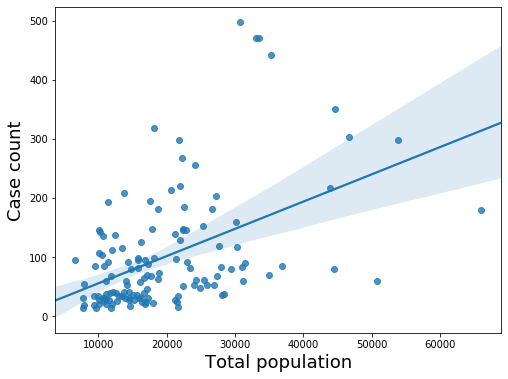

In [54]:
plt.figure(figsize = (8,6),facecolor = 'white')
sns.regplot(df_combined_sorted['Total Population'],df_combined_sorted['Case Count'],'o')
plt.xlabel('Total population', fontsize = 18)
plt.ylabel('Case count', fontsize = 18)
plt.show()

#### Figure 3

Text(0, 0.5, 'Number of deaths')

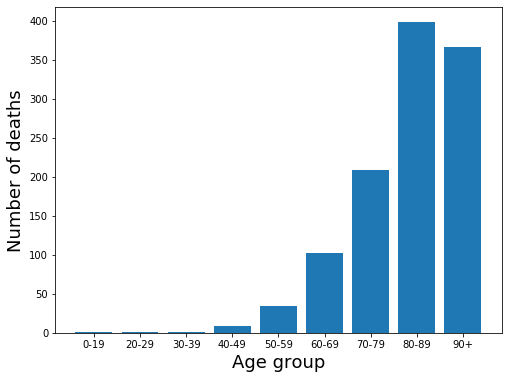

In [55]:
fig = plt.figure(figsize = (8,6),facecolor = 'white')
plt.bar(df_severity['Age Group'][0:-1],df_severity['Deaths'][0:-1])
plt.xlabel('Age group', fontsize = 18)
plt.ylabel('Number of deaths', fontsize = 18)

#### Figure 4

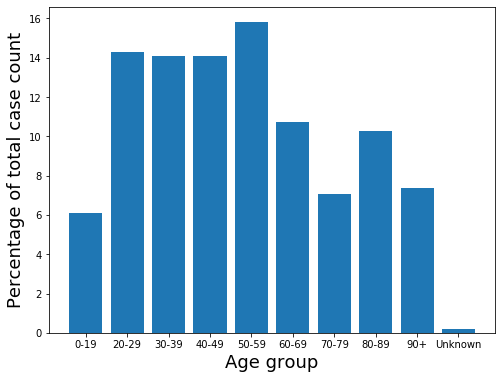

In [56]:
fig = plt.figure(figsize = (8,6),facecolor = 'white')
plt.bar(df_age['Age Group'],df_age['% of Total Case Count'])
plt.xlabel('Age group', fontsize = 18)
plt.ylabel('Percentage of total case count', fontsize = 18)
plt.show()

In [57]:
df_merge_col = df_merge_col.sort_values(by = 'Total Population', ascending = False)

- Creating dataframes for `young`, `middle aged` and `senior` age groups for data visualization.

In [58]:
young = df_merge_col[['Pop 0 - 19','Total Population','Case Count','Neighbourhood Name','Neighbourhood ID']]
young = young.sort_values(by = 'Pop 0 - 19', ascending = True)

In [59]:
mid = pd.DataFrame()
mid['Pop 20 - 59'] = df_merge_col['Pop 20 - 29'] + df_merge_col['Pop 30 - 39'] + df_merge_col['Pop 40 - 49'] + df_merge_col['Pop 50 - 59']
midaged = mid.join(df_merge_col[['Total Population','Case Count','Neighbourhood Name','Neighbourhood ID']])
midaged = midaged.sort_values(by = 'Pop 20 - 59', ascending = True)

In [60]:
senior = pd.DataFrame()
senior['Pop 60+'] = df_merge_col['Pop 60 - 69'] + df_merge_col['Pop 70 - 79'] + df_merge_col['Pop 80 - 89'] + df_merge_col['Pop 90+']
seniors = senior.join(df_merge_col[['Total Population','Case Count','Neighbourhood Name','Neighbourhood ID']])
seniors = seniors.sort_values(by = 'Pop 60+', ascending = True)

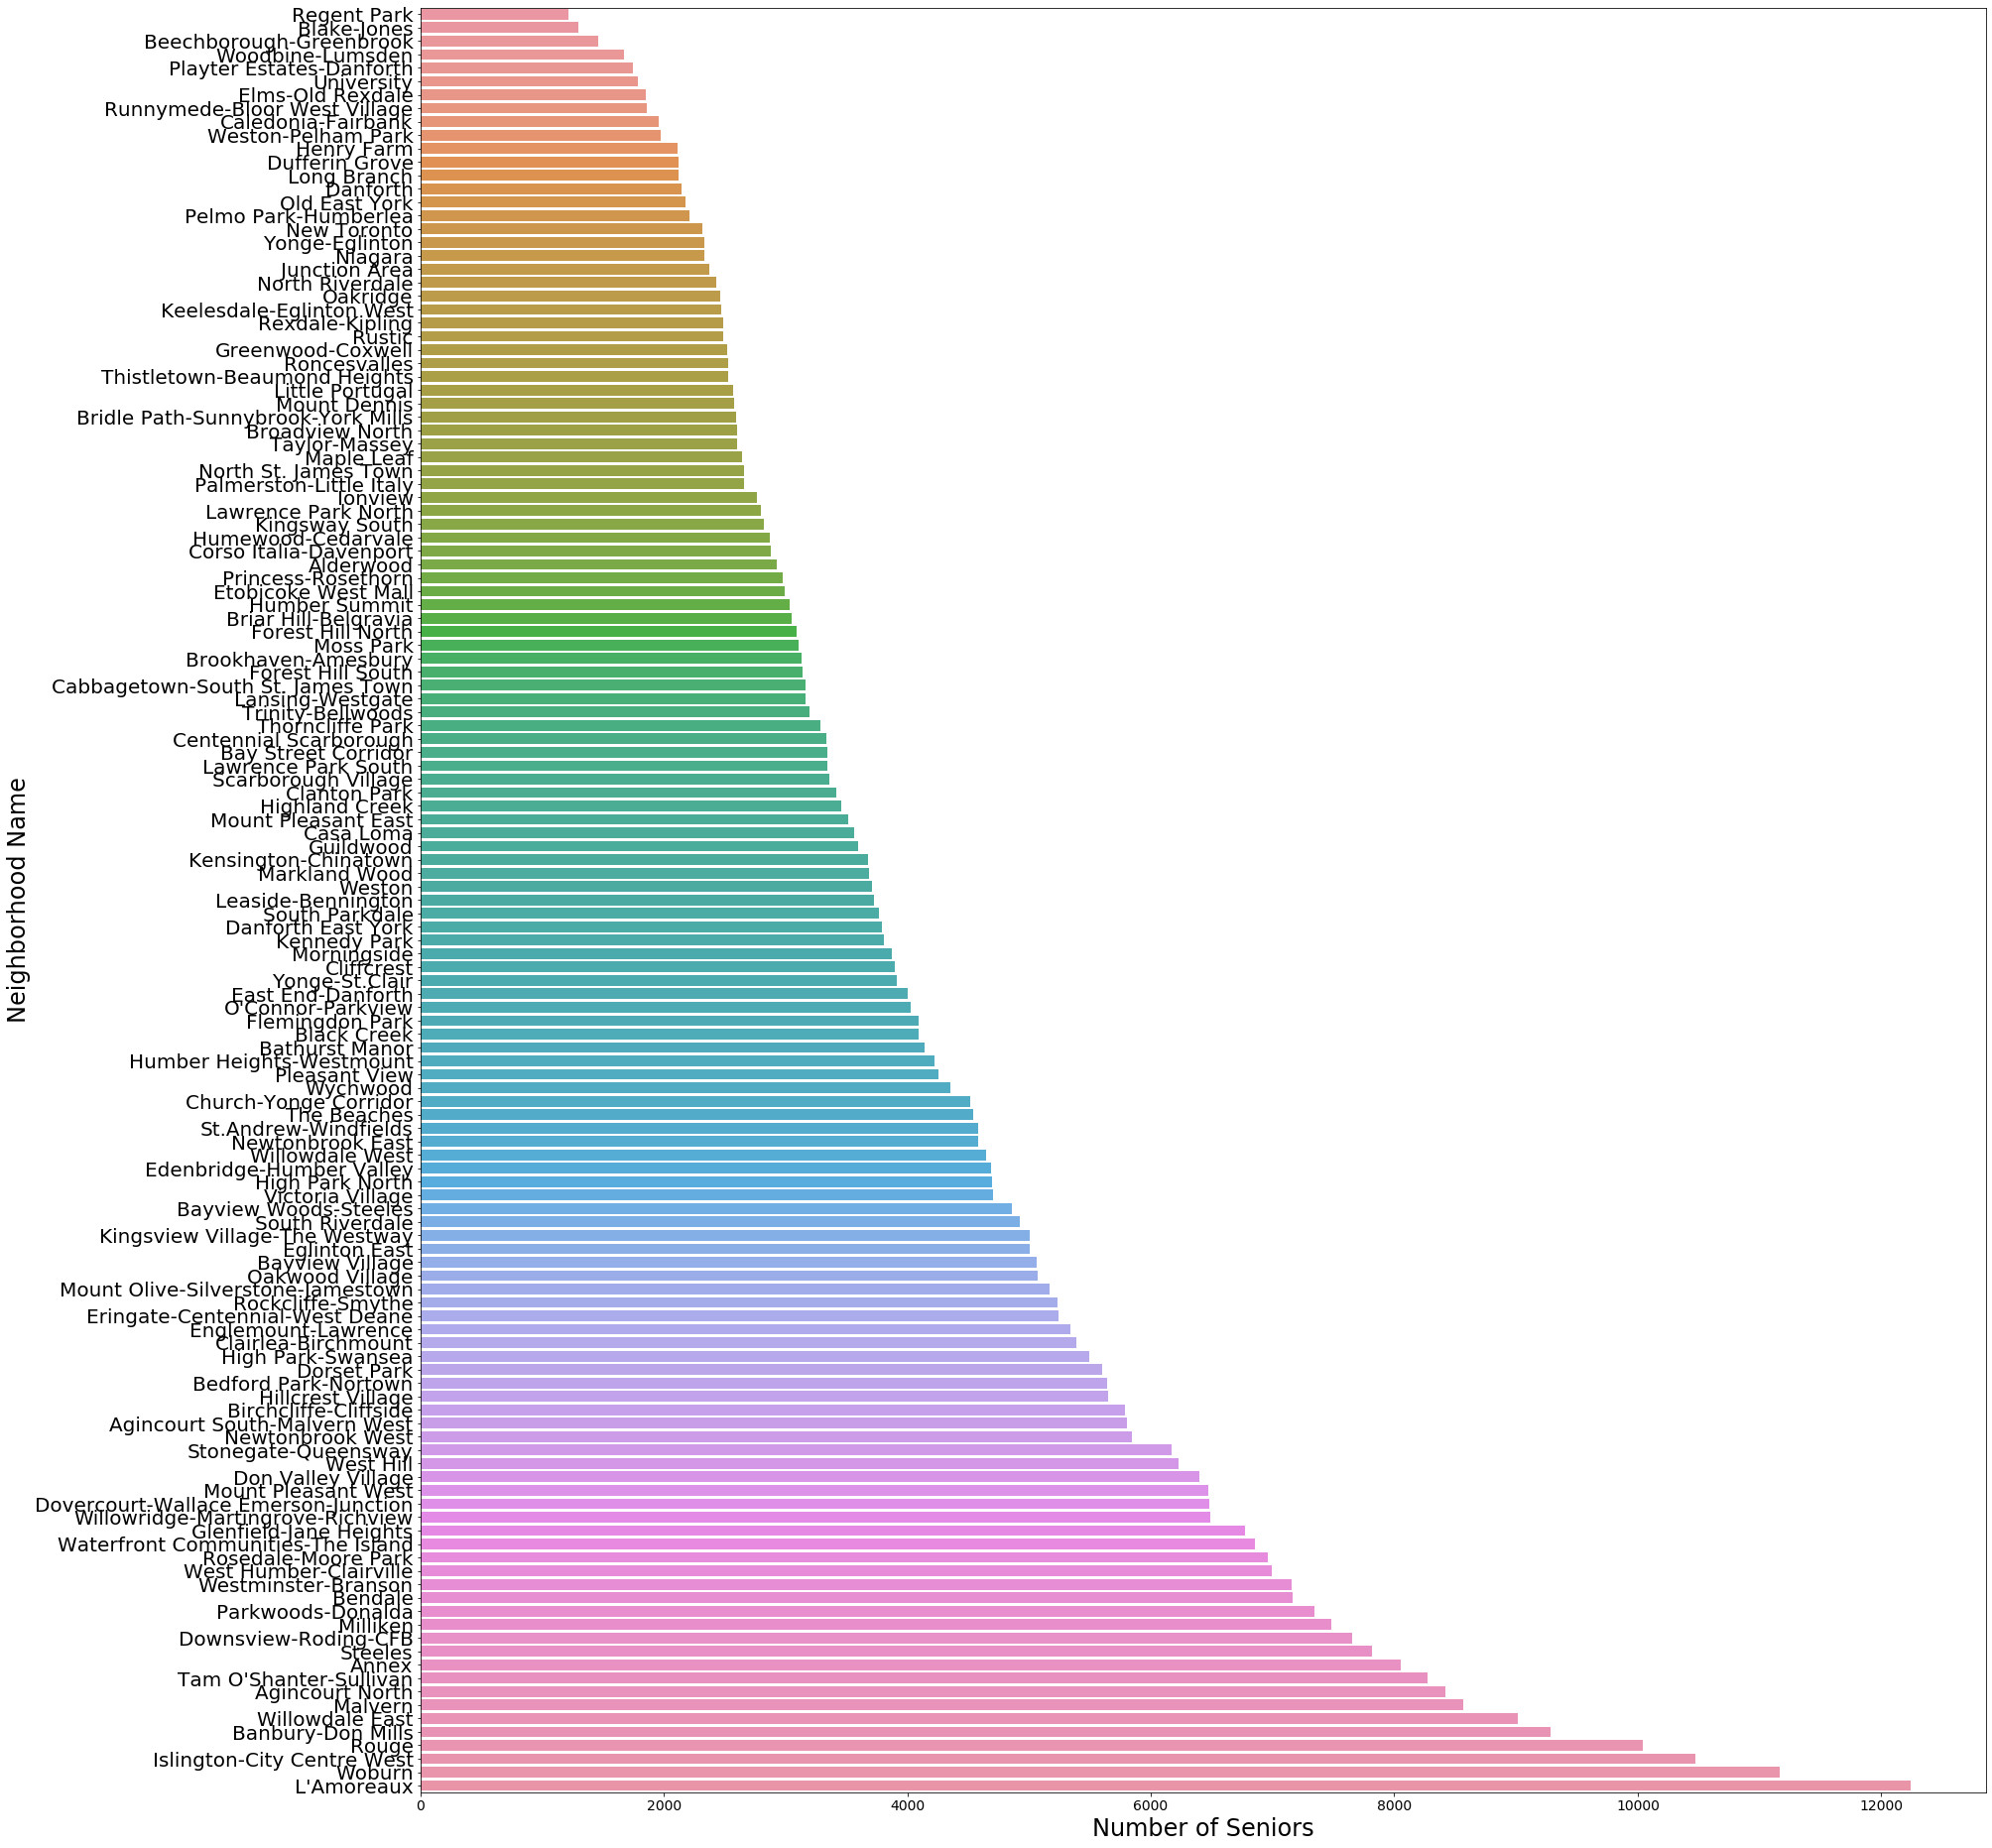

In [61]:
fig = plt.figure(figsize = (28,26),facecolor = 'white')
sns.barplot(seniors['Pop 60+'], seniors['Neighbourhood Name'])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 20)
plt.ylabel('Neighborhood Name', fontsize = 24)
plt.xlabel('Number of Seniors', fontsize = 24)
plt.tight_layout()

#### Figure 5

Text(0, 0.5, 'Neighborhood Name')

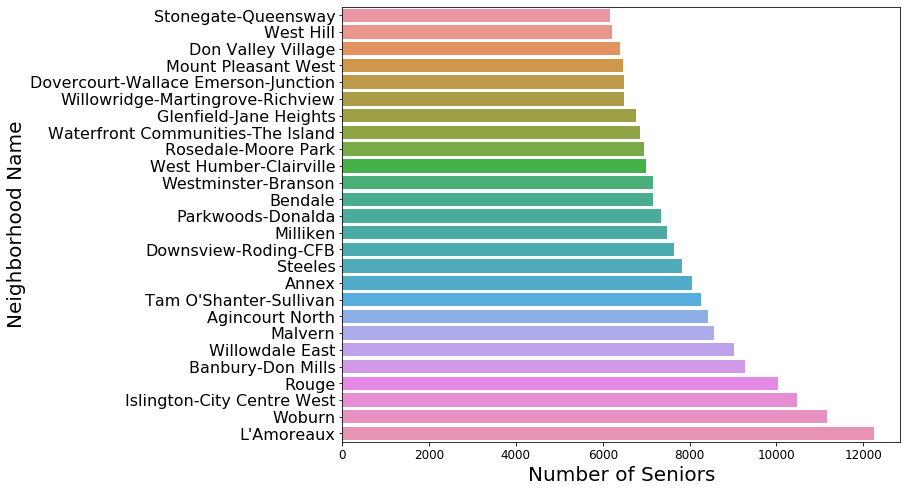

In [62]:
fig = plt.figure(figsize = (10,8),facecolor = 'white')
sns.barplot(seniors.loc[seniors['Pop 60+']>=6000]['Pop 60+'],seniors.loc[seniors['Pop 60+']>=6000]['Neighbourhood Name'])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)
plt.xlabel('Number of Seniors', fontsize = 20)
plt.ylabel('Neighborhood Name', fontsize = 20)

- Percentage of each age group compared with total population of Toronto:

In [63]:
print('Percentage of young population in Toronto: ',np.round(100*sum(young['Pop 0 - 19'])/sum(young['Total Population']),2))

Percentage of young population in Toronto:  19.72


In [64]:
print('Percentage of middle aged population in Toronto: ',np.round(100*sum(midaged['Pop 20 - 59'])/sum(midaged['Total Population']),2))

Percentage of middle aged population in Toronto:  58.28


In [65]:
print('Percentage of seniors population in Toronto: ',np.round(100*sum(seniors['Pop 60+'])/sum(seniors['Total Population']),2))

Percentage of seniors population in Toronto:  22.0


#### Figure 6

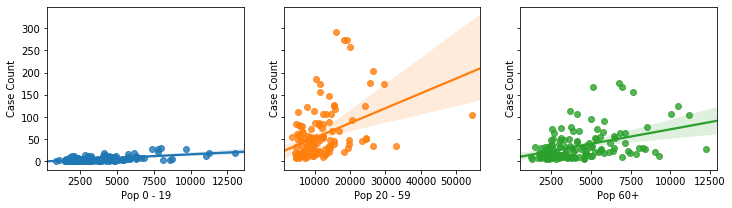

In [66]:
fig, ax = plt.subplots(figsize = (12,3), facecolor = 'white', ncols=3, sharey=True)
sns.regplot(young['Pop 0 - 19'],young['Case Count']*df_age.iloc[0,1]/100, label = 'young', ax = ax[0])
sns.regplot(midaged['Pop 20 - 59'],midaged['Case Count']*sum(df_age.iloc[1:5,1])/100, label = 'middle aged', ax = ax[1])
sns.regplot(seniors['Pop 60+'],seniors['Case Count']*sum(df_age.iloc[5:9,1])/100, label = 'senior', ax = ax[2])
plt.show()

#### Figure 7

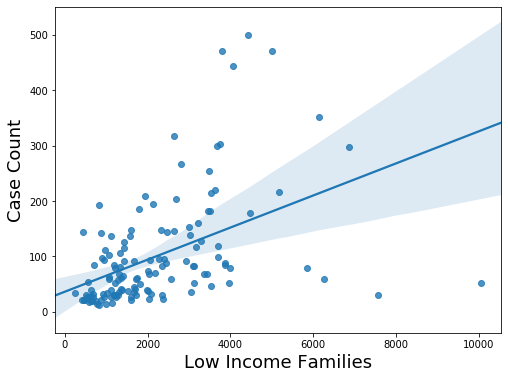

In [67]:
plt.figure(figsize = (8,6),facecolor = 'white')
sns.regplot(df_merge_col['Low Income Families'],df_merge_col['Case Count'],'o')
plt.xlabel('Low Income Families', fontsize = 18)
plt.ylabel('Case Count', fontsize = 18)
plt.show()

#### Figure 8

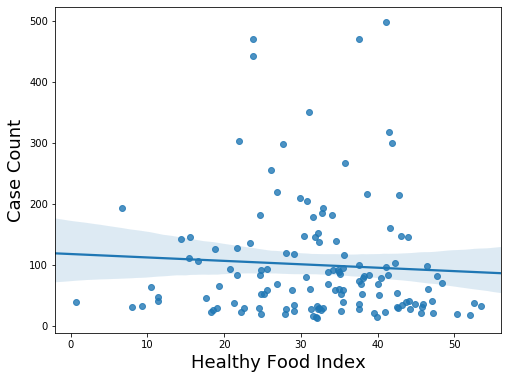

In [68]:
plt.figure(figsize = (8,6),facecolor = 'white')
sns.regplot(df_merge_col['Healthy Food Index'],df_merge_col['Case Count'],'o')
plt.xlabel('Healthy Food Index', fontsize = 18)
plt.ylabel('Case Count', fontsize = 18)
plt.show()

- Preparing `venue_count` dataframe for visualization.

In [69]:
venue_count['Neighbourhood']= venue_count.index
venue_count.reset_index(inplace = True)
venue_count.drop(columns = 'Neighborhood', inplace = True)

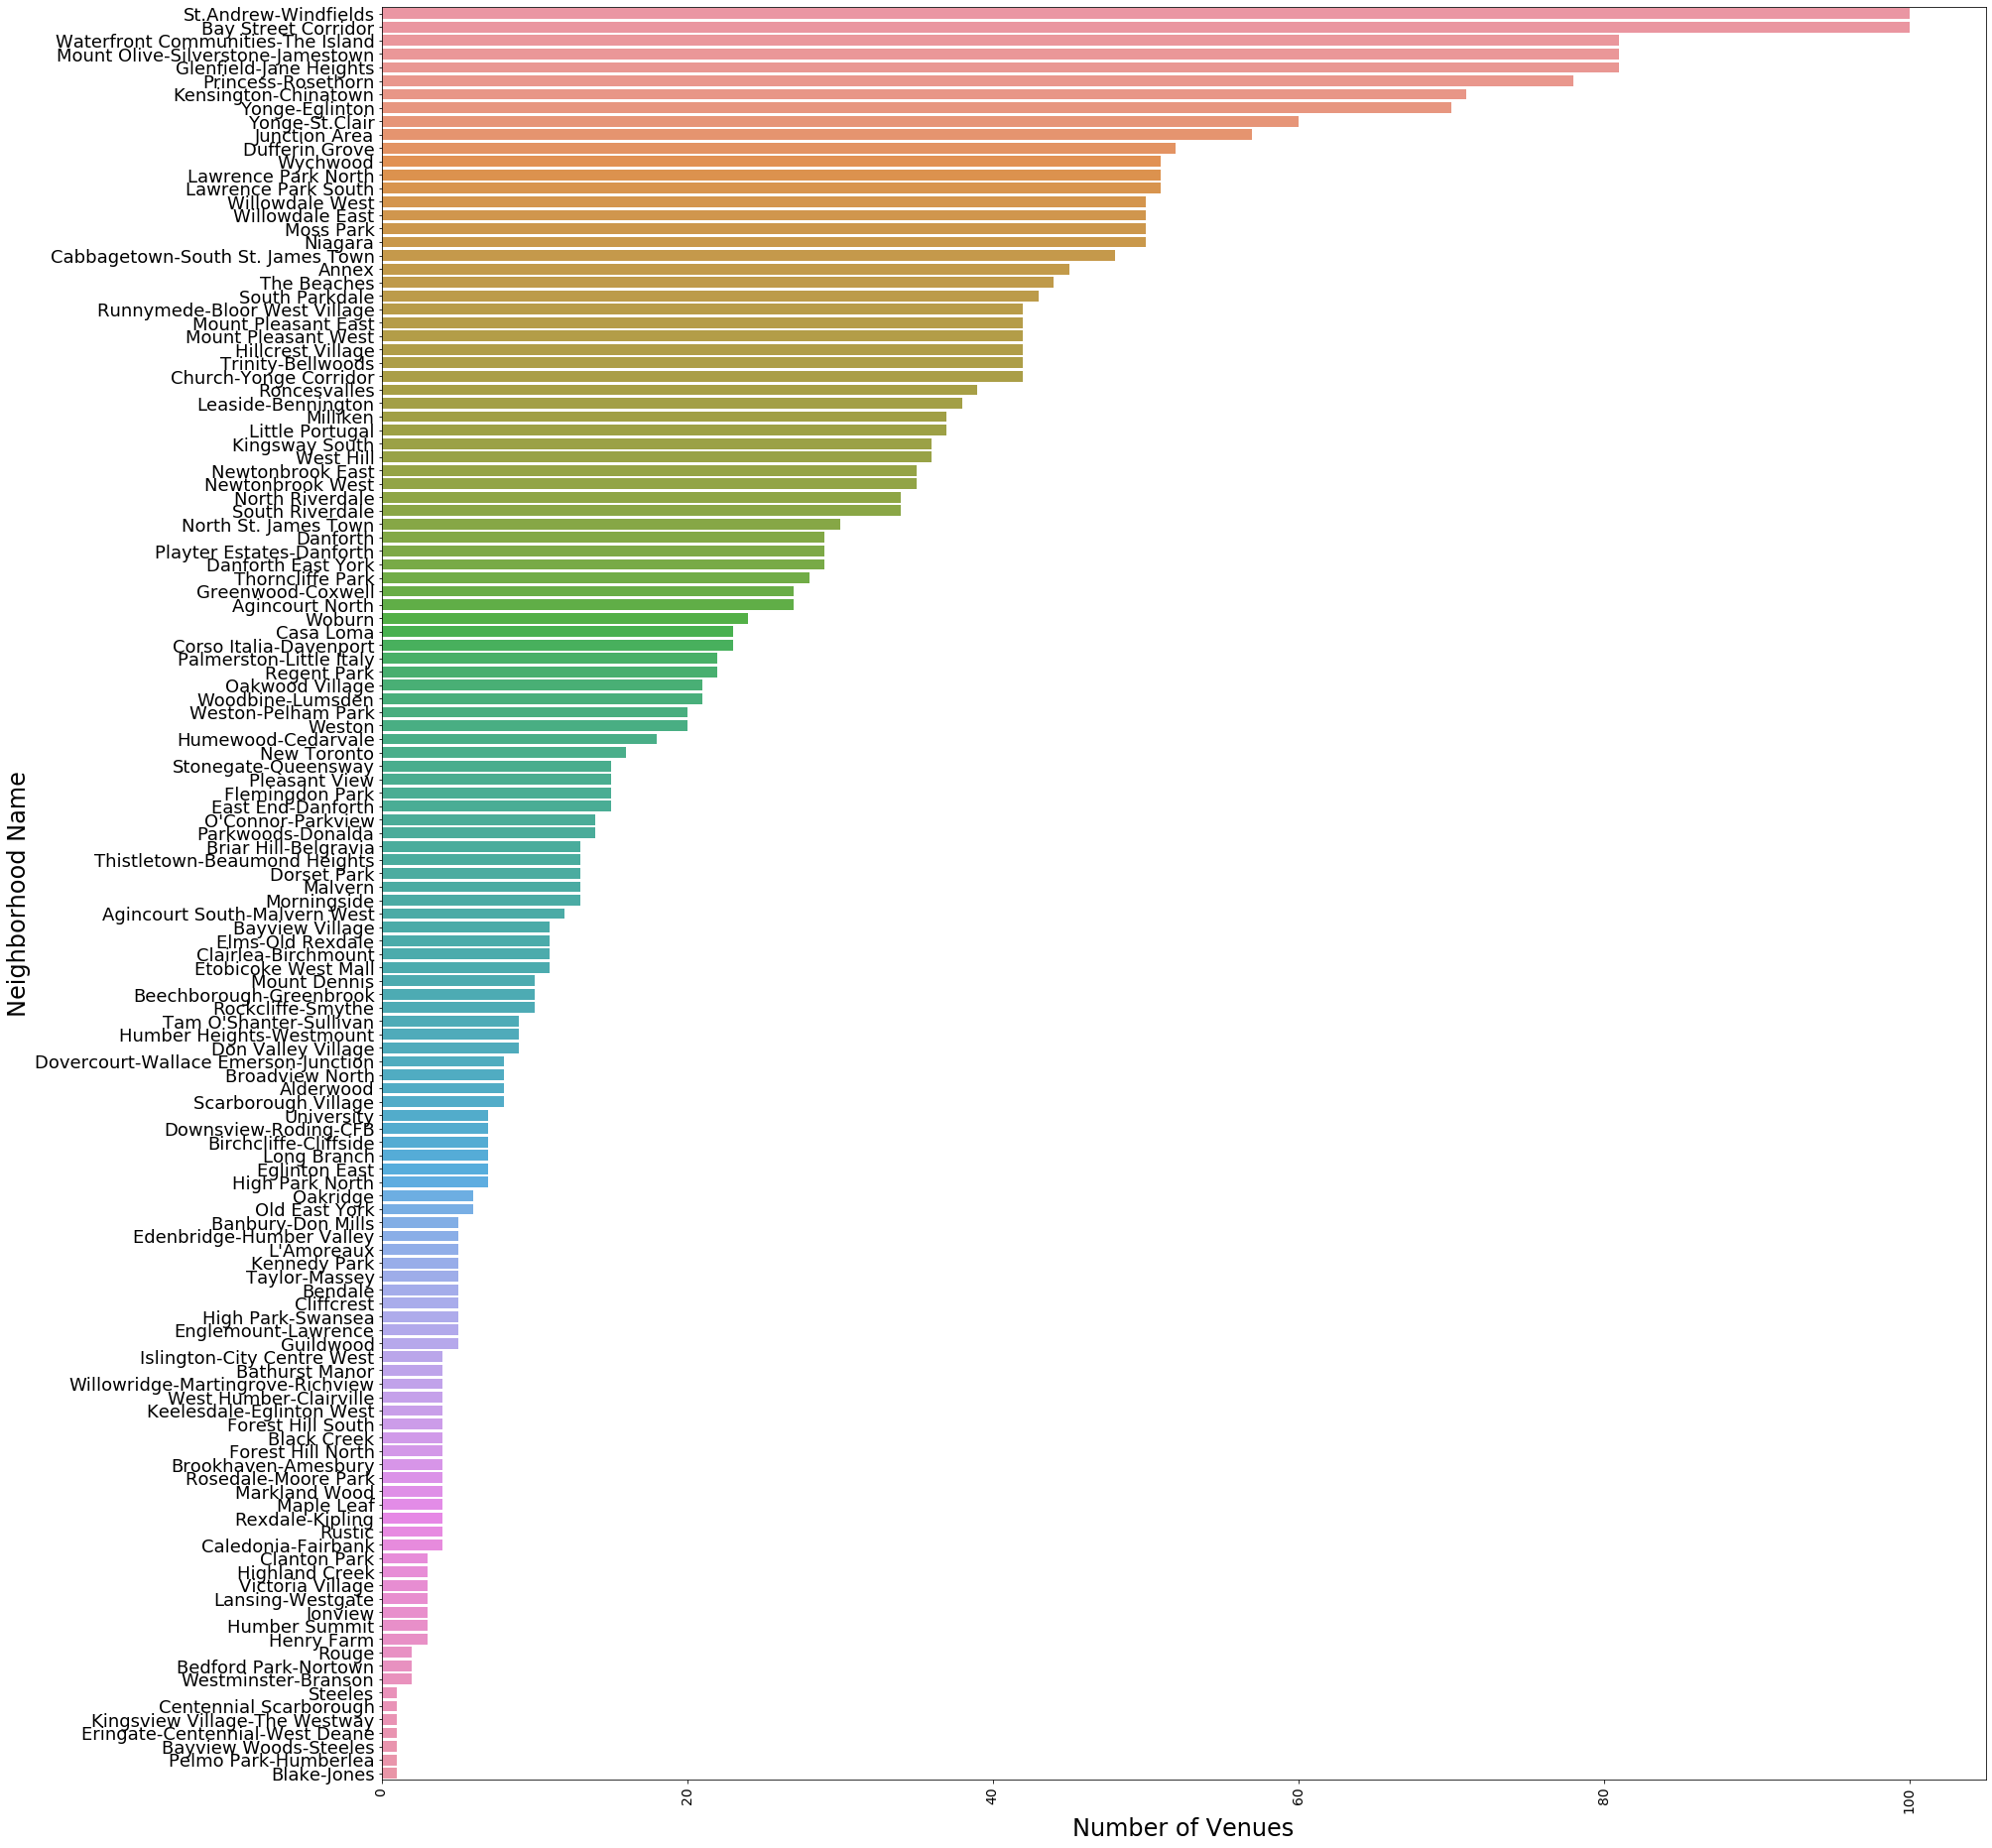

In [70]:
fig = plt.figure(figsize = (28,26),facecolor = 'white')
sns.barplot(venue_count['Number_of_Venues'],venue_count.Neighbourhood)
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 18)
plt.ylabel('Neighborhood Name', fontsize = 24)
plt.xlabel('Number of Venues', fontsize = 24)
plt.tight_layout()

Text(0, 0.5, 'Neighborhood Name')

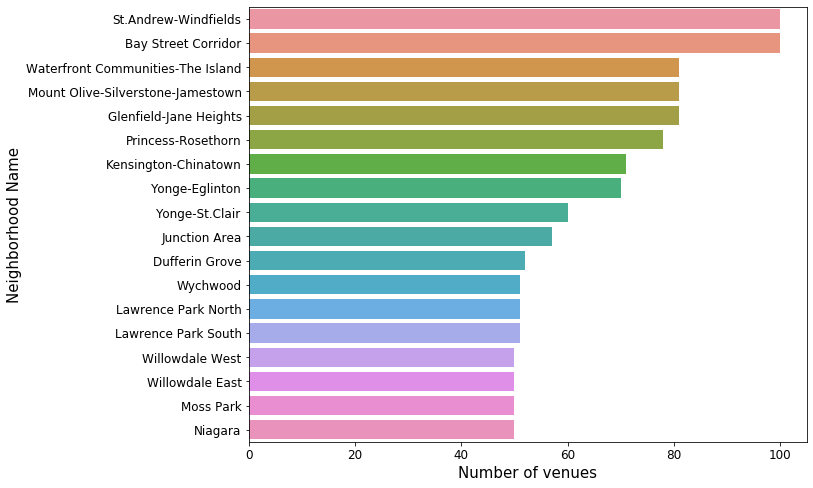

In [71]:
fig = plt.figure(figsize = (10,8),facecolor = 'white')
sns.barplot(venue_count.loc[venue_count['Number_of_Venues']>=50]['Number_of_Venues'],venue_count.loc[venue_count['Number_of_Venues']>=50]['Neighbourhood'])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Number of venues', fontsize = 15)
plt.ylabel('Neighborhood Name', fontsize = 15)

In [72]:
df_combined_sorted.columns

Index(['Neighbourhood ID', 'Neighbourhood Name', 'Case Count',
       'Rate per 100,000 people', 'Latitude', 'Longitude',
       'Low Income Families', 'Healthy Food Index', 'Total Area',
       'Total Population', 'Pop 0 - 19', 'Pop 20 - 29', 'Pop 30 - 39',
       'Pop 40 - 49', 'Pop 50 - 59', 'Pop 60 - 69', 'Pop 70 - 79',
       'Pop 80 - 89', 'Pop 90+', 'Density', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue', 'Number_of_Venues'],
      dtype='object')

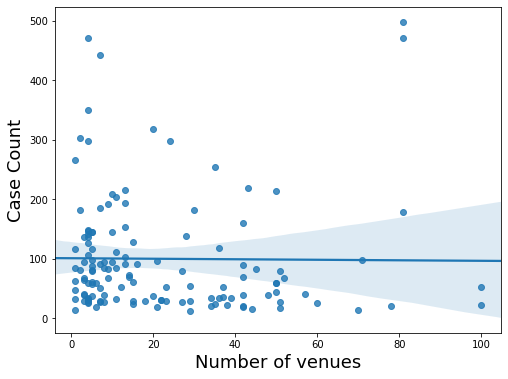

In [73]:
plt.figure(figsize = (8,6),facecolor = 'white')
sns.regplot(df_combined_sorted['Number_of_Venues'],df_combined_sorted['Case Count'],'o')
plt.xlabel('Number of venues', fontsize = 18)
plt.ylabel('Case Count', fontsize = 18)
plt.show()

In [74]:
temp_var = df_combined_sorted.sort_values(by = 'Neighbourhood Name')['Case Count'].reset_index()
temp_var.drop(columns = 'index', inplace = True)
toronto_grouped['Case Count'] = temp_var

In [75]:
toronto_grouped0 = toronto_grouped.sort_values(by = 'Case Count', ascending = False).reset_index()
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped0.drop(['Neighborhood','Case Count','index'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering.iloc[0:75,:])

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [76]:
df_combined_sorted.columns

Index(['Neighbourhood ID', 'Neighbourhood Name', 'Case Count',
       'Rate per 100,000 people', 'Latitude', 'Longitude',
       'Low Income Families', 'Healthy Food Index', 'Total Area',
       'Total Population', 'Pop 0 - 19', 'Pop 20 - 29', 'Pop 30 - 39',
       'Pop 40 - 49', 'Pop 50 - 59', 'Pop 60 - 69', 'Pop 70 - 79',
       'Pop 80 - 89', 'Pop 90+', 'Density', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue', 'Number_of_Venues'],
      dtype='object')

In [77]:
df_combined_sorted.drop(columns = ['Pop 0 - 19', 'Pop 20 - 29', 'Pop 30 - 39',
       'Pop 40 - 49', 'Pop 50 - 59', 'Pop 60 - 69', 'Pop 70 - 79',
       'Pop 80 - 89', 'Pop 90+'], inplace = True)

In [78]:
seniors = seniors.sort_values(by = 'Case Count', ascending = False).reset_index()
midaged = midaged.sort_values(by = 'Case Count', ascending = False).reset_index()
young = young.sort_values(by = 'Case Count', ascending = False).reset_index()

In [79]:
df_combined_sorted['Pop 0 - 19'] = young['Pop 0 - 19']
df_combined_sorted['Pop 20 - 59'] = midaged['Pop 20 - 59']
df_combined_sorted['Pop 60+'] = seniors['Pop 60+']

In [80]:
df1st40 = df_combined_sorted.iloc[0:75,:]

In [81]:
# add clustering labels
df1st40.insert(0, 'Cluster Labels', kmeans.labels_)

In [95]:
# create map
map_clusters = folium.Map(location=[latitude0, longitude0], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, case in zip(df1st40['Latitude'], df1st40['Longitude'], df1st40['Neighbourhood Name'], df1st40['Cluster Labels'], df_combined_sorted['Case Count'].astype(int)):
    label = folium.Popup(str(poi) + ', '+' Cluster: ' + str(cluster+1) +', ' + 'Cases: '+str(case), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [83]:
cluster1 = df1st40.loc[df1st40['Cluster Labels'] == 0, df1st40.columns[[2,3] + list(range(5, df1st40.shape[1]))]]
cluster1.head()

,Neighbourhood Name,Case Count,Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number_of_Venues,Pop 0 - 19,Pop 20 - 59,Pop 60+
37,Bayview Woods-Steeles,116,43.7981,-79.383,1420,35.61,4.1,13480,3287.804878,Dog Run,Yoga Studio,Dumpling Restaurant,Dive Bar,Doctor's Office,1,2275,6350,4855


In [84]:
cluster1.iloc[:,9].value_counts()

Dog Run    1
Name: 1st Most Common Venue, dtype: int64

#### Cluster 2

In [85]:
cluster2 = df1st40.loc[df1st40['Cluster Labels'] == 1, df1st40.columns[[2,3] + list(range(5, df1st40.shape[1]))]]
cluster2.head()

,Neighbourhood Name,Case Count,Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number_of_Venues,Pop 0 - 19,Pop 20 - 59,Pop 60+
0,Glenfield-Jane Heights,499,43.6535,-79.3839,4420,41.05,5.20,30715,5906.730769,Clothing Store,Coffee Shop,Hotel,Seafood Restaurant,Electronics Store,81,8015,15925,6775
1,West Humber-Clairville,471,43.6824,-79.4808,3790,23.82,30.09,33525,1114.157527,Gas Station,Park,Coffee Shop,Donut Shop,Distribution Center,4,9690,19160,6990
2,Mount Olive-Silverstone-Jamestown,471,43.6535,-79.3839,5010,37.57,4.60,33080,7191.304348,Clothing Store,Coffee Shop,Hotel,Seafood Restaurant,Electronics Store,81,7375,18225,5165
3,Downsview-Roding-CFB,443,43.7493,-79.4622,4060,23.72,14.90,35285,2368.120805,Furniture / Home Store,Park,French Restaurant,Gas Station,Coffee Shop,7,7770,19865,7650
4,Islington-City Centre West,351,43.6488,-79.549,6140,31.01,16.40,44585,2718.597561,Pizza Place,Park,Fish & Chips Shop,Yoga Studio,Donut Shop,4,7780,26335,10470


In [86]:
cluster2.iloc[:,9].value_counts()

Coffee Shop                   10
Park                           7
Fast Food Restaurant           7
Pizza Place                    6
Clothing Store                 4
Furniture / Home Store         3
Bank                           3
Café                           2
Italian Restaurant             2
Construction & Landscaping     2
Restaurant                     1
Garden                         1
Gas Station                    1
Yoga Studio                    1
Tibetan Restaurant             1
Indian Restaurant              1
Bus Stop                       1
Supermarket                    1
Train Station                  1
Food Service                   1
Middle Eastern Restaurant      1
Turkish Restaurant             1
Bakery                         1
Pub                            1
Bar                            1
Rental Car Location            1
Mexican Restaurant             1
Diner                          1
Pet Store                      1
Ice Cream Shop                 1
Basketball

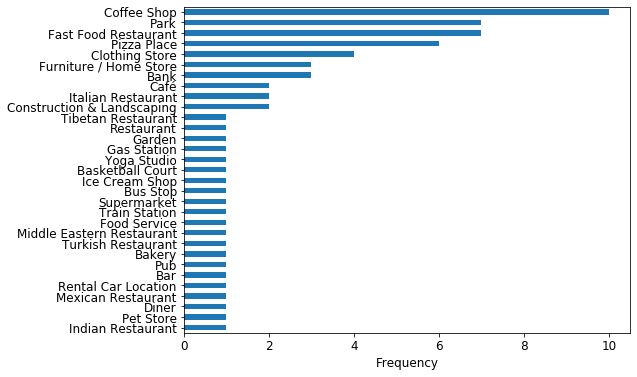

In [102]:
plt.figure(figsize = (8,6), facecolor = 'white')
cluster2.iloc[:,9].value_counts().sort_values().plot(kind = 'barh')
plt.xlabel('Frequency', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

#### Cluster 3

In [87]:
cluster3 = df1st40.loc[df1st40['Cluster Labels'] == 2, df1st40.columns[[2,3] + list(range(5, df1st40.shape[1]))]]
cluster3.head()

,Neighbourhood Name,Case Count,Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number_of_Venues,Pop 0 - 19,Pop 20 - 59,Pop 60+
6,Rouge,303,43.8049,-79.1658,3760,21.95,37.6,46765,1243.750000,Fast Food Restaurant,Park,Dumpling Restaurant,Dive Bar,Doctor's Office,2,11220,25500,10045
9,Kingsview Village-The Westway,267,43.6995,-79.5563,2800,35.69,5.1,22225,4357.843137,Park,Yoga Studio,Dumpling Restaurant,Dive Bar,Doctor's Office,1,5735,11485,5005
54,Pelmo Park-Humberlea,84,43.7122,-79.5176,710,21.71,4.2,10775,2565.476190,Park,Yoga Studio,Dumpling Restaurant,Dive Bar,Doctor's Office,1,2420,5180,2210
68,Clanton Park,65,43.7432,-79.4517,1410,19.35,4.2,16630,3959.523810,Park,Gym,Yoga Studio,Dumpling Restaurant,Dive Bar,3,3710,9505,3415
69,Eringate-Centennial-West Deane,63,43.6623,-79.5765,1060,10.43,8.6,18750,2180.232558,Park,Yoga Studio,Dumpling Restaurant,Dive Bar,Doctor's Office,1,3790,9715,5245


In [88]:
cluster3.iloc[:,9].value_counts()

Park                    4
Fast Food Restaurant    1
Name: 1st Most Common Venue, dtype: int64

#### Cluster 4

In [89]:
cluster4 = df1st40.loc[df1st40['Cluster Labels'] == 3, df1st40.columns[[2,3] + list(range(5, df1st40.shape[1]))]]
cluster4.head()

,Neighbourhood Name,Case Count,Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number_of_Venues,Pop 0 - 19,Pop 20 - 59,Pop 60+
58,Bedford Park-Nortown,81,43.7374,-79.4109,1340,47.74,5.5,23485,4270.0,Seafood Restaurant,Rental Car Location,Donut Shop,Distribution Center,Dive Bar,2,6280,11560,5645


In [90]:
cluster4.iloc[:,9].value_counts()

Seafood Restaurant    1
Name: 1st Most Common Venue, dtype: int64

#### Cluster 5

In [91]:
cluster5 = df1st40.loc[df1st40['Cluster Labels'] == 4, df1st40.columns[[2,3] + list(range(5, df1st40.shape[1]))]]
cluster5.head()

,Neighbourhood Name,Case Count,Latitude,Longitude,Low Income Families,Healthy Food Index,Total Area,Total Population,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Number_of_Venues,Pop 0 - 19,Pop 20 - 59,Pop 60+
46,Henry Farm,94,43.7695,-79.3543,2060,20.8,2.6,15755,6059.615385,Tennis Court,Park,Lawyer,Dumpling Restaurant,Dive Bar,3,1545,3655,1465


In [92]:
cluster5.iloc[:,9].value_counts()

Tennis Court    1
Name: 1st Most Common Venue, dtype: int64